In [1]:
import sys
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

In [2]:
rescale_f = 38000

In [16]:
M = pymc.database.hdf5.load('D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12')
M_L = pymc.database.hdf5.load('D:/PyMC_DataBase/post_model_150_30-350_30-250_20_1000iter50burn.hdf5')
#prior_model = pymc.database.pickle.load('D:/PyMC_DataBase/prior_model_1_1000iter_2017_11_11')

In [17]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:]

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

interp_trace = M.trace('interp_unc')[:]
max_volume_trace = structural_model_trace[:,0]
SSF_trace = structural_model_trace[:,1]
trap_control_trace = structural_model_trace[:,2]


res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
structural_model_trace_L = M_L.trace('structural_model')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

interp_trace_L = M_L.trace('interp_unc')[:]
max_volume_trace_L = structural_model_trace_L[:,0]
SSF_trace_L = structural_model_trace_L[:,1]
trap_control_trace_L = structural_model_trace_L[:,2]

In [25]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s

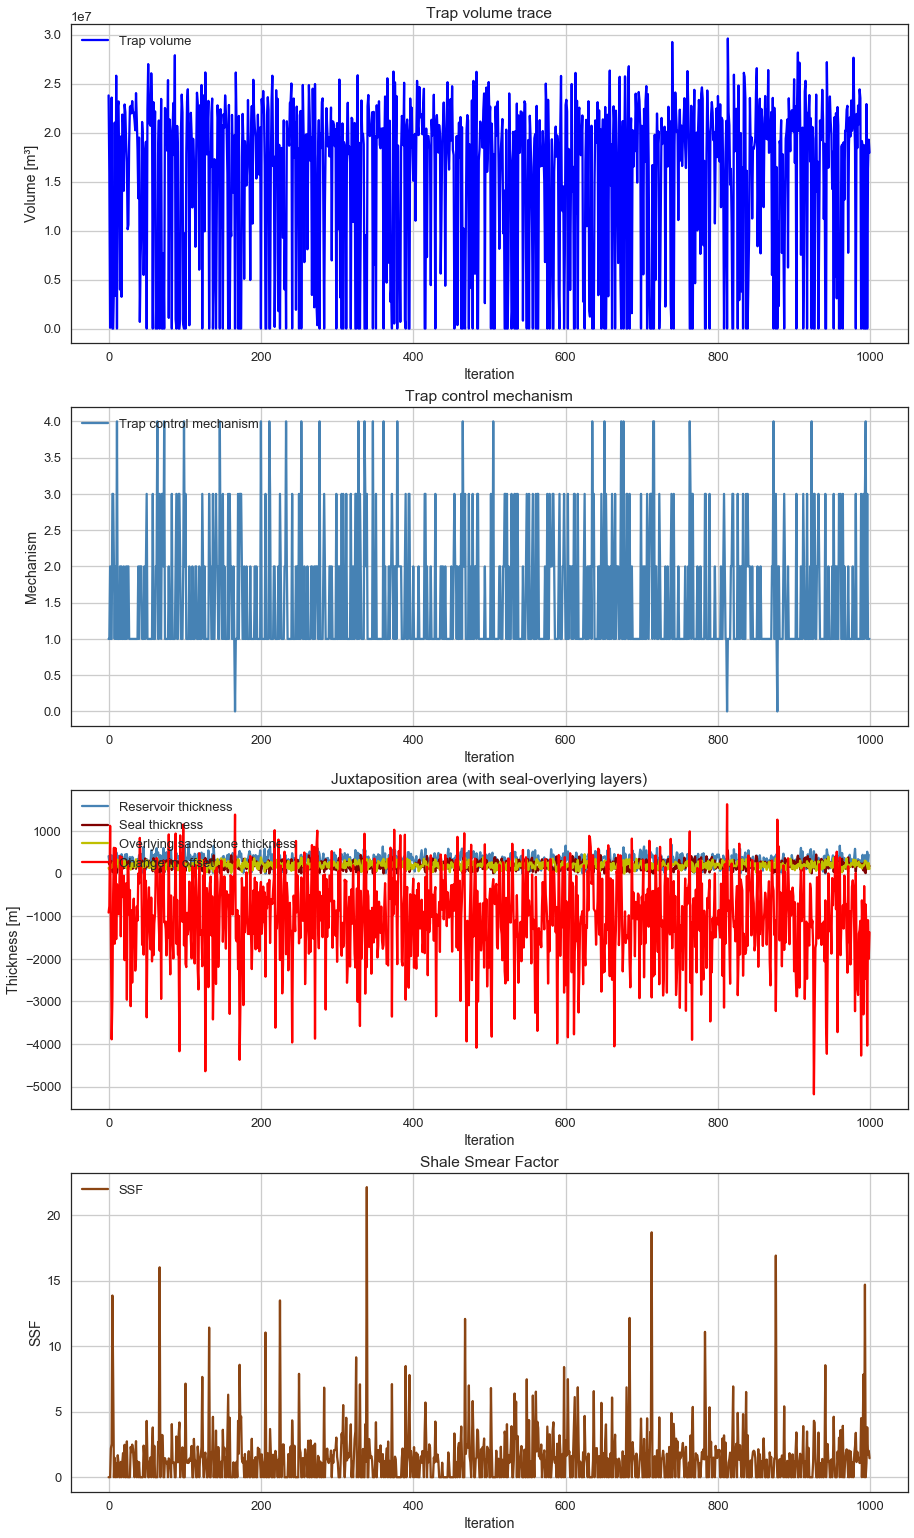

In [6]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


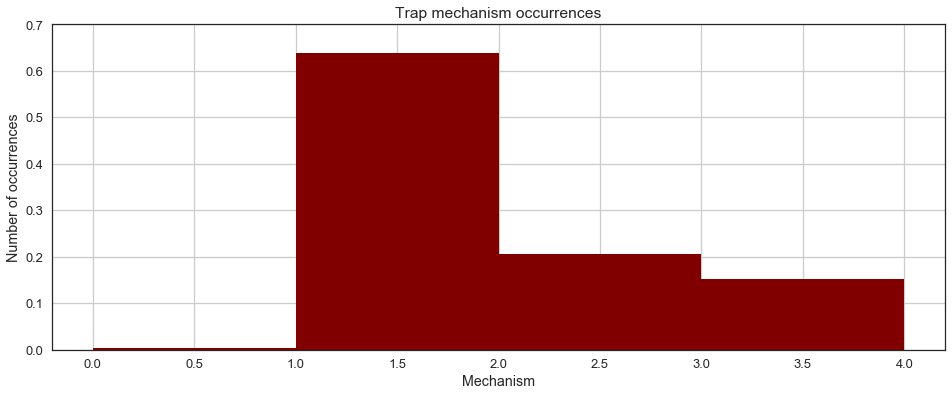

In [7]:
figsize(16, 6)
_hist1 = plt.hist(trap_control_trace, bins=4, normed=True, 
                  histtype="stepfilled", color = "maroon")
plt.title("Trap mechanism occurrences")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.ylabel("Number of occurrences")
plt.xlabel("Mechanism")

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


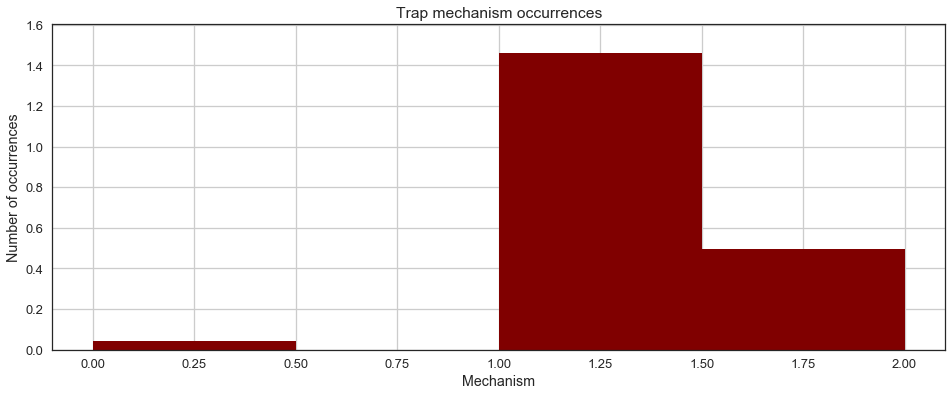

In [18]:
figsize(16, 6)
_hist1 = plt.hist(trap_control_trace_L, bins=4, normed=True, 
                  histtype="stepfilled", color = "maroon")
plt.title("Trap mechanism occurrences")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.ylabel("Number of occurrences")
plt.xlabel("Mechanism")

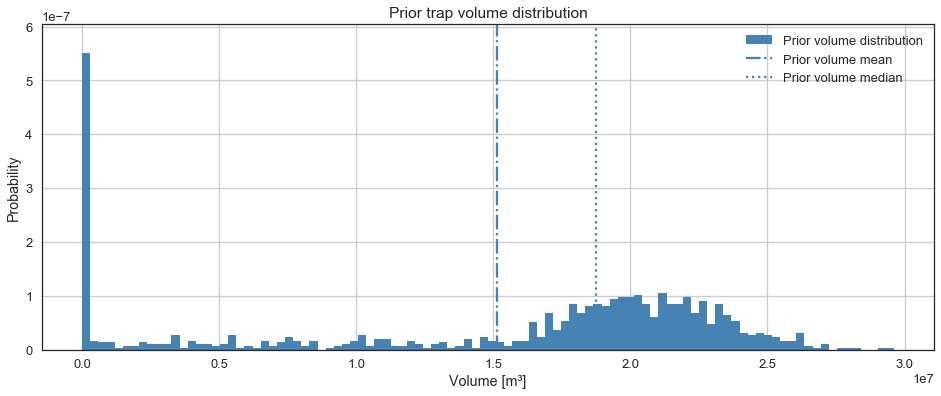

In [8]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

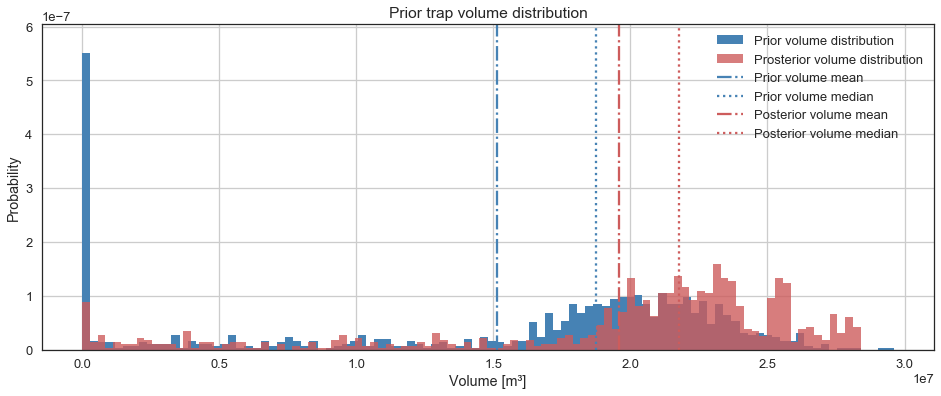

In [19]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
_hist2 = plt.hist(max_volume_trace_L, bins=100, normed=True, 
                  histtype="stepfilled",label="Prosterior volume distribution", color="indianred", alpha = 0.8)
_hist_scale = np.append(_hist1[0],_hist2[0])
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist_scale), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist_scale), label="Prior volume median", linestyles=":", color = "steelblue")
plt.vlines(max_volume_trace_L.mean(), 0, 1.1 * np.max(_hist_scale), label="Posterior volume mean", linestyles="-.", color = "indianred")
plt.vlines(np.median(max_volume_trace_L), 0, 1.1 * np.max(_hist_scale), label="Posterior volume median", linestyles=":", color = "indianred")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist_scale)+1, np.max(_hist_scale)/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist_scale))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

Bayes action (minimum) at risk r 0.50: 22784000.00 --- expected loss: 3568033.00
Bayes action (minimum) at risk r 0.75: 21856000.00 --- expected loss: 4834016.50
Bayes action (minimum) at risk r 1.00: 21224000.00 --- expected loss: 5976858.00
Bayes action (minimum) at risk r 1.25: 20672000.00 --- expected loss: 7032545.50
Bayes action (minimum) at risk r 1.50: 20120000.00 --- expected loss: 8013782.00


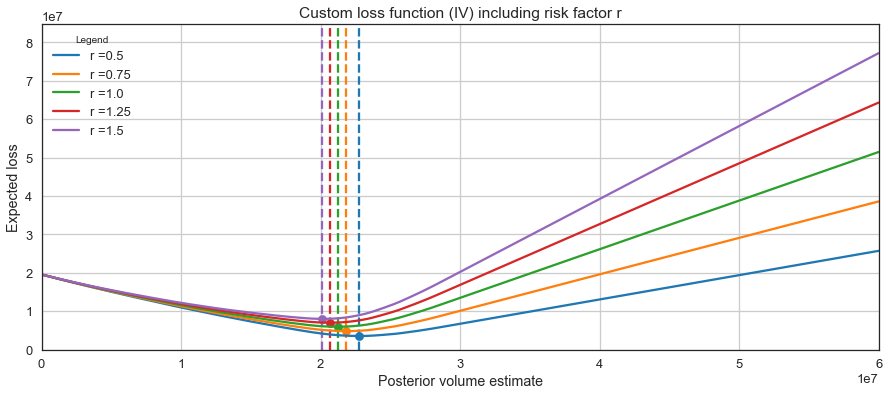

In [22]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace_L, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Posterior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

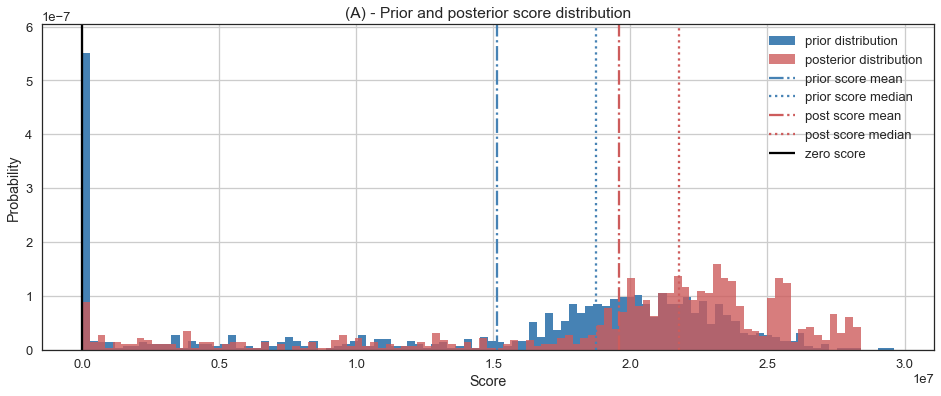

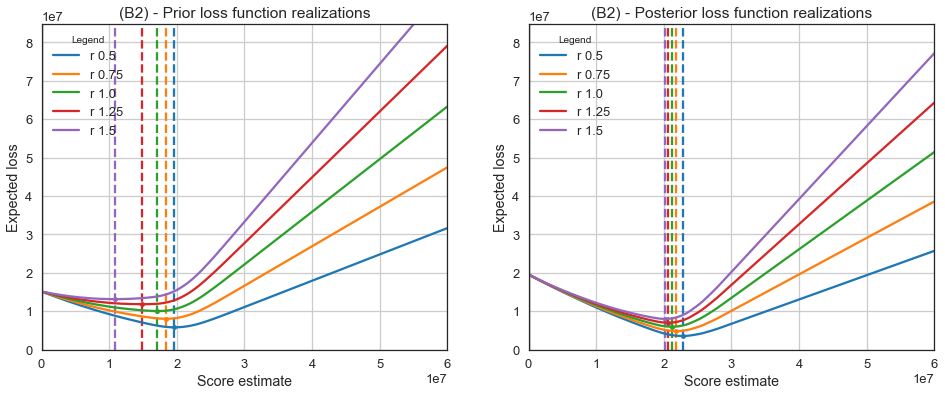

In [31]:
figsize(16, 6)

_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

_hist2 = plt.hist(max_volume_trace_L, bins=100, normed=True, histtype="stepfilled",label="posterior distribution", color = "indianred", alpha = 0.8)

plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="prior score mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="prior score median", linestyles=":", color = "steelblue")

plt.vlines(max_volume_trace_L.mean(), 0, 1.1 * np.max(_hist1[0]), label="post score mean", linestyles="-.", color = "indianred")
plt.vlines(np.median(max_volume_trace_L), 0, 1.1 * np.max(_hist1[0]), label="post score median", linestyles=":", color = "indianred")

plt.vlines(0, 0, 1.1 * np.max(_hist1[0]), label="zero score", linestyles="-")

plt.title("(A) - Prior and posterior score distribution")
plt.legend(loc="upper right");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Score")
plt.ylabel("Probability")

figsize(16, 6)
fig, ax = plt.subplots(1, 2)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss_sB1 = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace, risk_s).mean()

counter = 0
for r in risks_s:
    _color = next(ax[0]._get_lines.prop_cycler)
    loss = [expected_loss_sB1(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_sB1, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    ax[0].plot(estimates_s, loss, label = "r "+str(r), color = _color['color'])
    ax[0].scatter(_min_score, expected_loss_sB1(_min_score,r), s = 20, color = _color['color'])
    ax[0].vlines(_min_score, 0,100000000, color=_color['color'], linestyles="--")
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss_sB1(_min_score,r)
    counter += 1

# Reduced uncertainty, different risks
BA_after = np.zeros_like(risks_s)
EL_after = np.zeros_like(risks_s)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace_L, risk_s).mean()

counter = 0
for r in risks_s:
    _color = next(ax[1]._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_score < 0:
        _min_score = 0
    ax[1].plot(estimates_s, loss, label = "r "+str(r), color = _color['color'])
    ax[1].scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = _color['color'])
    ax[1].vlines(_min_score, 0, 100000000, color=_color['color'], linestyles="--")
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_after[counter] = _min_score
    EL_after[counter] = expected_loss_s(_min_score,r)
    counter += 1

#B1 layout
ax[0].set_title("""(B2) - Prior loss function realizations""")    
ax[0].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#ax[0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#ax[0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0].set_xlabel("Score estimate")
ax[0].set_ylabel("Expected loss")
ax[0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0].set_ylim(0,1.1 * np.max(loss))
ax[0].grid()

#B2 layout
ax[1].set_title("""(B2) - Posterior loss function realizations""")    
ax[1].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#ax[1].vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#ax[1].vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1].set_xlabel("Score estimate")
ax[1].set_ylabel("Expected loss")
ax[1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1].set_ylim(0,1.1 * np.max(loss))
ax[1].grid()